# Background information
*   This notebooks contains the data analytic pipeline for the manuscript titled "Understanding Policing: A Quantitative Analysis" and submitted to *Perspectives on Behavior Science*.
*   Data for this notebook can be obtained from the Stanford Police Project: https://openpolicing.stanford.edu/data/. 

In [24]:
# Packages!!
import os
import sys
import pandas as pd
import numpy as np
import scipy
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Upload data 
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/MyDrive/Policing Data/Charlotte/Data'
raw_data = pd.read_csv("nc_charlotte_2020_04_01.csv")
data = raw_data.copy()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: './gdrive/MyDrive/Policing Data/Charlotte/Data'
/content/gdrive/MyDrive/Policing Data/Charlotte/Data


In [26]:
# Sample of what the data looks like and the data types
data.head()

,raw_row_number,date,time,location,county_name,subject_age,subject_race,subject_sex,officer_id_hash,department_name,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_frisk,reason_for_search,reason_for_stop,raw_Ethnicity,raw_Race,raw_action_description
0,3254,2000-01-01,17:20:00,Unknown,NaN,38.0,black,female,22e35044ed,UNC Charlotte University P...,vehicular,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,Safe Movement Violation,N,B,Verbal Warning
1,3259,2000-01-02,11:40:00,Unknown,NaN,33.0,hispanic,male,22e35044ed,UNC Charlotte University P...,vehicular,False,True,False,citation,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,Vehicle Regulatory Violation,H,W,Citation Issued
2,3281,2000-01-02,02:41:00,Unknown,NaN,23.0,white,male,22e35044ed,UNC Charlotte University P...,vehicular,False,True,False,citation,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,Vehicle Equipment Violation,N,W,Citation Issued
3,3282,2000-01-23,03:35:00,Unknown,NaN,23.0,white,female,22e35044ed,UNC Charlotte University P...,vehicular,False,True,False,citation,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,Vehicle Regulatory Violation,N,W,Citation Issued
4,3283,2000-01-02,16:45:00,Unknown,NaN,23.0,white,female,22e35044ed,UNC Charlotte University P...,vehicular,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,Safe Movement Violation,N,W,Verbal Warning


In [27]:
# Create year and month cols for grouping
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month

# Distributions of stops and putative reinforcers per month for all officers

In [28]:
# Create individual data frames for the different independent and dependent variables
offcr_stops = data.groupby(['year', 'month', 'officer_id_hash']).size()
offcr_cites = data.groupby(['year', 'month', 'officer_id_hash', 'citation_issued']).size()
offcr_search = data.groupby(['year', 'month', 'officer_id_hash', 'search_conducted']).size()
offcr_frisk = data.groupby(['year', 'month', 'officer_id_hash', 'frisk_performed']).size()
offcr_contra = data.groupby(['year', 'month', 'officer_id_hash', 'contraband_found']).size()
offcr_arrest = data.groupby(['year', 'month', 'officer_id_hash', 'arrest_made']).size()

In [29]:
# Print descriptions of each subset dataframe 
from scipy.stats import skew
grouped_data = [offcr_stops, offcr_cites, offcr_search, offcr_frisk, offcr_contra, offcr_arrest]
data_type = ['Stops', 'Citations', 'Searches', 'Frisks', 'Contraband Found', 'Arrests']

for i in range(len(grouped_data)):
  print(data_type[i], "| Skew =", round(skew(grouped_data[i]), 4), "\n", grouped_data[i].describe(), "\n")

Stops | Skew = 4.8332 
 count    132786.000000
mean         12.037813
std          18.480945
min           1.000000
25%           3.000000
50%           6.000000
75%          14.000000
max         378.000000
dtype: float64 

Citations | Skew = 6.8317 
 count    220808.000000
mean          7.239108
std          12.534817
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         365.000000
dtype: float64 

Searches | Skew = 5.5246 
 count    170977.000000
mean          9.348936
std          16.356146
min           1.000000
25%           2.000000
50%           4.000000
75%          10.000000
max         364.000000
dtype: float64 

Frisks | Skew = 4.8523 
 count    134204.000000
mean         11.910621
std          18.409985
min           1.000000
25%           2.000000
50%           6.000000
75%          14.000000
max         378.000000
dtype: float64 

Contraband Found | Skew = 3.8762 
 count    50438.000000
mean         1.841508
std          

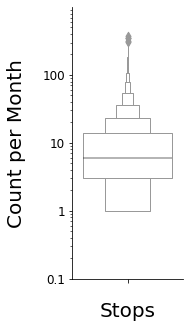

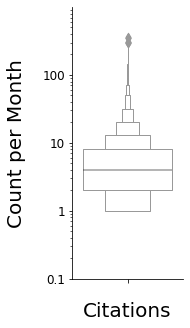

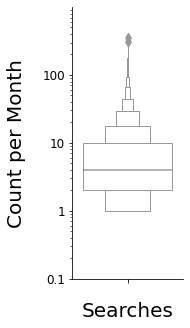

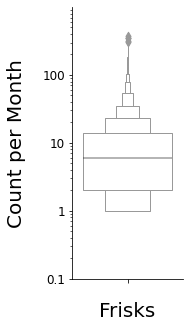

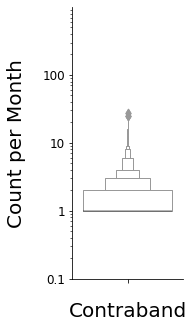

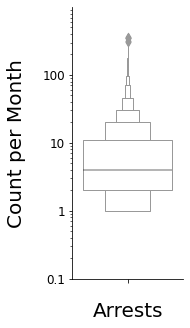

In [30]:
# Plot letter-value plots / boxen plots of the different distributions. 
# NB: These are Figure 1 in the manuscript
def boxen(df, x_label):
  f, ax = plt.subplots(figsize=(2, 5))
  sns.boxenplot(y=df, color='white')
  plt.xlabel(x_label, fontsize=20, labelpad=(16))
  plt.ylabel('Count per Month', fontsize=20, labelpad=(16))
  plt.ylim(.1, 1000)
  plt.yscale("log")
  plt.yticks(ticks=[.1, 1, 10, 100], labels=['0.1', '1', '10', '100'], fontsize=12)
  # plt.yticks(fontsize=12)
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

boxen(offcr_stops, 'Stops')
boxen(offcr_cites, 'Citations')
boxen(offcr_search, 'Searches')
boxen(offcr_frisk, 'Frisks')
boxen(offcr_contra, 'Contraband')
boxen(offcr_arrest, 'Arrests')

# Define single-alternative matching equation

In [31]:
# Define single alternative matching equation and import packages we'll need to
# play with it.  
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def single_match(x, k, re):
  return (k*x)/(x+re)

# Fit single-alternative matching to each officer's data

In [32]:
# Function for fitting single-alternative equation
def single_matching(df, unique_identifier, df_reinforcer, reinforcer_label, 
                    fit_df_name, subset_cat=None, month=False):
  """
    Function Inputs:
    ----------
    df: Dataframe from which to subset the individual officer data. 
    unique_identifier: Dataframe column containing the individual person id. 
    df_reinforcer: The column that contains the reinforcer being tested. 
    reinforcer_label: The label to assign to the reinforcer being tested. 
    fit_df_name: Name of the fit dataframe that is saved by running this function. 
    subset_cat: Column to subsetting df for fitting across different categories.
    month: True if binning by month and year. False if binning only by year. 

    DESCRIPTION: This function fits the single-altenative matching equation 
        (Herrnstein, 1970) to behavior data binned per month for every 
        officer in this dataframe. It is designed so you can run through a loop 
        and test a variety of potential reinforcers in your data set, determine 
        which one best describes each officer's data, and save the results. 

    Returns:
    -------
    None. Pandas dataframe automatically saved after every officer. The 
    auto-saved dataframe contains:
      (1) Unique officer id number
      (2) Reinforcer label
      (3) The subset category of the data for each fit (if specified)
      (4) The estimated k parameter for the single-alternative matching equation. 
      (5) The estimated Re parameter for the single-alternative matching equation. 
      (6) The variance accounted for by the single-alternative matching equation. 
  """
  import warnings
  warnings.filterwarnings('ignore')

  # Create list of all the unique officers in the dataset
  uniq_persons = df[unique_identifier].unique()
  
  # Lists for storing data
  person_num = []
  fit_type = []
  reinforcer_type = []
  k_val = []
  re_val = []
  r2_val = []
  error_list = []

  for i in uniq_persons:
    # Subset single officer data
    person_hash = i
    person_A = df[df[unique_identifier]==i]
    person_A = person_A[person_A['time'].notna()]
    person_A = person_A.reset_index()

    # Obtain rate of behavior per month and rate of citations per month
    person_reinforcer = person_A.groupby(['year', 'month'])[df_reinforcer].sum()
    person_behavior = person_A.groupby(['year', 'month']).size()

    if len(person_behavior) > 5:
      try:
        reinforcer_per_day = person_reinforcer / 30.42  # Convert to rate per day
        behavior_per_day = person_behavior / 30.42  # Convert to rate per day

        # Fit the single-alt matching equation to the officer data
        behavior = behavior_per_day.values
        reinforcer = reinforcer_per_day.values
        c, cov = curve_fit(single_match, reinforcer, behavior) # Fit model
        preds_from_obs = single_match(reinforcer, *c)  # Make predictions based on model params
        r_2 = r2_score(behavior, preds_from_obs) # Calculate vac to see how well the model fits

        # Append data to cols
        person_num.append(person_hash)
        reinforcer_type.append(reinforcer_label)
        fit_type.append('overall')
        k_val.append(c[0])
        re_val.append(c[1])
        r2_val.append(round(r_2, 4))

        # Save data
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)

        # Run the same analysis, but grouped by race
        # Calculate rate of behavior per day and rate of citations per day
        if month==True:
          person_reinforcer = person_A.groupby(['year', 'month', subset_cat])[df_reinforcer].sum().unstack()
          person_behavior = person_A.groupby(['year', 'month', subset_cat]).size().unstack()
          reinforcer_per_day = person_reinforcer / 30.42
          behavior_per_day = person_behavior / 30.42
        else:
          person_reinforcer = person_A.groupby(['year', subset_cat])[df_reinforcer].sum().unstack()
          person_behavior = person_A.groupby(['year', subset_cat]).size().unstack()
          reinforcer_per_day = person_reinforcer / 12
          behavior_per_day = person_behavior / 12
        reinforcer_per_day = reinforcer_per_day.fillna(0)
        behavior_per_day = behavior_per_day.fillna(0)

        # Loop through each race and fit the model
        cols = list(reinforcer_per_day)
        race_plot = []
        k_plot = []
        re_plot = []
        r2_plot = []

        for k in cols:
          behavior = behavior_per_day[k].values
          reinforcer = reinforcer_per_day[k].values
          param_seeds = [16, 5]
          c, cov = curve_fit(single_match, reinforcer, behavior) # Fit model
          preds_from_obs = single_match(reinforcer, *c) # Make predictions based on model params
          r_2 = r2_score(behavior, preds_from_obs) # Calculate vac to see how well the model fits

          # Append data to cols
          person_num.append(person_hash)
          reinforcer_type.append(reinforcer_label)
          fit_type.append(k)
          race_plot.append(k)
          k_val.append(c[0])
          k_plot.append(c[0])
          re_val.append(c[1])
          re_plot.append(c[1])
          r2_val.append(round(r_2, 4))
          r2_plot.append(round(r_2, 4))

        # Save data
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)
    
      except:
        error_list.append(i)
        err_officers = pd.DataFrame(error_list)
        err_officers.to_csv('Error_List_%s.csv' %reinforcer_label)
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)

In [33]:
# Citations as putative reinforcer binned by month
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='citation_issued', reinforcer_label='citations', 
                fit_df_name='All_Fits_Citations', subset_cat='subject_race', 
                month=True)

In [34]:
# Searches as putative reinforcers binned by year
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='search_conducted', reinforcer_label='searches', 
                fit_df_name='All_Fits_Searches', subset_cat='subject_race')

In [35]:
# Frisk as putative reinforcers binned by year
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='frisk_performed', reinforcer_label='frisks', 
                fit_df_name='All_Fits_Frisks', subset_cat='subject_race')

In [36]:
# Contraband as putative reinforcers binned by year
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='contraband_found', reinforcer_label='contraband', 
                fit_df_name='All_Fits_Contraband', subset_cat='subject_race')

In [37]:
# Arrests as putative reinforcers binned by year
single_matching(df=data, unique_identifier='officer_id_hash', 
                df_reinforcer='arrest_made', reinforcer_label='arrests', 
                fit_df_name='All_Fits_Arrests', subset_cat='subject_race')

# Combine all fit dataframes into single dataframe

In [38]:
# Combine all fit dataframes into single dataframe
cite_fits = pd.read_csv('All_Fits_Citations.csv')
cite_fits = cite_fits.drop(['Unnamed: 0'], axis=1)
search_fits = pd.read_csv('All_Fits_Searches.csv')
search_fits = search_fits.drop(['Unnamed: 0'], axis=1)
frisk_fits = pd.read_csv('All_Fits_Frisks.csv')
frisk_fits = frisk_fits.drop(['Unnamed: 0'], axis=1)
contra_fits = pd.read_csv('All_Fits_Contraband.csv')
contra_fits = contra_fits.drop(['Unnamed: 0'], axis=1)
arrest_fits = pd.read_csv('All_Fits_Arrests.csv')
arrest_fits = arrest_fits.drop(['Unnamed: 0'], axis=1)

all_fits = cite_fits.append([cite_fits, search_fits, frisk_fits, contra_fits, arrest_fits])
all_fits.to_csv('All_Single_Alt_Matching_Fits.csv')

In [39]:
all_fits.columns = ['person_num', 'reinforcer', 'fit_type', 'est_k', 'est_re', 'vac']

# Proportion descriptions for ms

In [40]:
# Distribution vals for everything
pd.set_option('max_colwidth', 30) 
pd.set_option('max_rows', len(all_fits))
all_fits.groupby(['fit_type', 'reinforcer']).describe()

est_k                ...       vac        
                                    count          mean  ...       75%     max
fit_type               reinforcer                        ...                  
asian/pacific islander arrests     1877.0  5.474661e+03  ... -0.333300  1.0000
                       citations   3886.0  1.988500e+05  ...  0.698575  1.0000
                       contraband  1877.0  1.570820e+00  ... -0.378800  1.0000
                       frisks      1877.0  1.177777e+00  ... -0.412800  1.0000
                       searches    1877.0  5.780208e+04  ... -0.300000  1.0000
black                  arrests     2109.0  1.657505e+07  ...  0.611400  1.0000
                       citations   4412.0  7.740808e+05  ...  0.781900  1.0000
                       contraband  2109.0  1.162526e+07  ...  0.215200  1.0000
                       frisks      2109.0  6.989993e+05  ... -1.038500  0.9990
                       searches    2109.0  2.763456e+07  ...  0.731000  1.0000
hispanic               arrests     2073.0  3.401658e+06  ... -0.061200  1.0000
                       citations   4324.0  4.922182e+05  ...  0.806800  1.0000
                       contraband  2073.0  7.736663e+05  ... -0.600000  1.0000
                       frisks      2073.0  1.129953e+04  ... -0.832600  1.0000
                       searches    2073.0  3.842873e+06  ...  0.199300  1.0000
other                  arrests      427.0  1.022344e+00  ... -0.083300  1.0000
                       citations    862.0  2.221256e+04  ...  1.000000  1.0000
                       contraband   427.0  1.014343e+00  ... -0.090900  1.0000
                       frisks       427.0  1.000195e+00  ... -0.100000  0.1333
                       searches     427.0  1.035017e+00  ... -0.083300  1.0000
overall                arrests     2206.0  8.527571e+04  ... -0.450150  0.9589
                       citations   4412.0  1.397975e+06  ...  0.831700  0.9999
                       contraband  2206.0  3.389596e+04  ... -0.811900  0.6437
                       frisks      2206.0  9.890451e+02  ... -1.177300  0.0000
                       searches    2206.0  9.415948e+04  ... -0.191650  0.9141
unknown                arrests     1747.0  1.117125e+05  ... -0.272700  1.0000
                       citations   3602.0  3.046463e+05  ...  0.759200  1.0000
                       contraband  1747.0  3.752446e+05  ... -0.312500  1.0000
                       frisks      1747.0  1.065144e+00  ... -0.333300  0.8636
                       searches    1747.0  4.230139e+05  ... -0.250000  1.0000
white                  arrests     2105.0  1.003573e+07  ...  0.005400  1.0000
                       citations   4404.0  7.418881e+05  ...  0.758100  1.0000
                       contraband  2105.0  7.368811e+06  ... -0.555300  1.0000
                       frisks      2105.0  2.327474e+03  ... -1.014000  0.9074
                       searches    2105.0  1.370794e+07  ...  0.339700  1.0000

[35 rows x 24 columns]

In [41]:
# Print the proportion of officers whose databehavior was described by the 
# single-alternative matching equation with vac greater than 90%
print((round((cite_fits['vac'].ge(0.9).sum())/len(cite_fits), 5)), "= Citation Proportion >90%")
print((round((search_fits['vac'].ge(0.9).sum())/len(search_fits), 5)), "= Search Proportion >90%")
print((round((frisk_fits['vac'].ge(0.9).sum())/len(frisk_fits), 5)), "= Frisk Proportion >90%")
print((round((contra_fits['vac'].ge(0.9).sum())/len(contra_fits), 5)), "= Contraband Found Proportion >90%")
print((round((arrest_fits['vac'].ge(0.9).sum())/len(arrest_fits), 5)), "= Arrest Proportion >90%")

0.13482 = Citation Proportion >90%
0.04974 = Search Proportion >90%
0.0008 = Frisk Proportion >90%
0.01547 = Contraband Found Proportion >90%
0.03253 = Arrest Proportion >90%


In [42]:
# Print the proportion of officers whose databehavior was described by the 
# single-alternative matching equation with vac greater than 80%
print((round((cite_fits['vac'].ge(0.8).sum())/len(cite_fits), 5)), "= Citation Proportion >80%")
print((round((search_fits['vac'].ge(0.8).sum())/len(search_fits), 5)), "= Search Proportion >80%")
print((round((frisk_fits['vac'].ge(0.8).sum())/len(frisk_fits), 5)), "= Frisk Proportion >80%")
print((round((contra_fits['vac'].ge(0.8).sum())/len(contra_fits), 5)), "= Contraband Found Proportion >80%")
print((round((arrest_fits['vac'].ge(0.8).sum())/len(arrest_fits), 5)), "= Arrest Proportion >80%")

0.24106 = Citation Proportion >80%
0.07565 = Search Proportion >80%
0.00175 = Frisk Proportion >80%
0.02439 = Contraband Found Proportion >80%
0.05254 = Arrest Proportion >80%


In [43]:
# Print the number of officers for whom:
# VAC > 90%
print('VAC > 90%')
print(cite_fits['vac'].ge(0.9).sum(), "= Citation Count")
print(search_fits['vac'].ge(0.9).sum(), "= Search Count")
print(frisk_fits['vac'].ge(0.9).sum(), "= Frisk Count")
print(contra_fits['vac'].ge(0.9).sum(), "= Contraband Count")
print(arrest_fits['vac'].ge(0.9).sum(), "= Arrest Count")

# VAC > 80%
print('\nVAC > 80%')
print(cite_fits['vac'].ge(0.8).sum(), "= Citation Count")
print(search_fits['vac'].ge(0.8).sum(), "= Search Count")
print(frisk_fits['vac'].ge(0.8).sum(), "= Frisk Count")
print(contra_fits['vac'].ge(0.8).sum(), "= Contraband Count")
print(arrest_fits['vac'].ge(0.8).sum(), "= Arrest Count")

VAC > 90%
1746 = Citation Count
624 = Search Count
10 = Frisk Count
194 = Contraband Count
408 = Arrest Count

VAC > 80%
3122 = Citation Count
949 = Search Count
22 = Frisk Count
306 = Contraband Count
659 = Arrest Count


In [44]:
# Create list of officers for whom vac was > 90% using Eq. 1
def offcrs_90(df):
  temp_list = []
  reinf = []
  for i in range(len(df)):
    if df['vac'][i]>=0.90:
      if df['person_num'][i] in temp_list:
        continue
      else:
        temp_list.append(df['person_num'][i])
        reinf.append(df['reinforcer'][i])
  return pd.DataFrame(list(zip(temp_list, reinf)), columns=['person_num', 'reinforcer'])

cites_offcr = offcrs_90(cite_fits)
search_offcr = offcrs_90(search_fits)
frisk_offcr = offcrs_90(frisk_fits)
contra_offcr = offcrs_90(contra_fits)
arrest_offcr = offcrs_90(arrest_fits)

# Combine all officer dfs where VAC was .90 or greater
all_offcr90s = cites_offcr.append(search_offcr)
all_offcr90s = all_offcr90s.append(frisk_offcr)
all_offcr90s = all_offcr90s.append(contra_offcr)
all_offcr90s = all_offcr90s.append(arrest_offcr)

# Show value counts for all_offcr90s df
print("Unique Officers with VAC > 0.90 = %s" %len(all_offcr90s['person_num'].unique()))
offcr90_val_counts = pd.DataFrame(all_offcr90s.value_counts(), columns=['count'])
offcr90_val_counts['count'].value_counts()

Unique Officers with VAC > 0.90 = 1122


1    1729
Name: count, dtype: int64

In [45]:
# Combine all officer dfs where VAC was .90 or greater
all_offcr90s = cites_offcr.append(search_offcr)
all_offcr90s = all_offcr90s.append(frisk_offcr)
all_offcr90s = all_offcr90s.append(contra_offcr)
all_offcr90s = all_offcr90s.append(arrest_offcr)

In [46]:
print("Unique Officers with VAC > 90 = %s" %len(all_offcr90s['person_num'].unique()))
offcr90_val_counts = pd.DataFrame(all_offcr90s.value_counts(), columns=['count'])
offcr90_val_counts['count'].unique()

Unique Officers with VAC > 90 = 1122


array([1])